# Оценка результатов A/B-теста для web-магазина

## Введение

Совместно с отделом маркетинга интернет-магазина подготовлен список гипотез для увеличения выручки и получены результаты A/B-теста.  
Требуется:  
- приоритизировать гипотезы;  
- проанализировать результаты теста. 

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv', parse_dates=['date']),
        pd.read_csv('visitors.csv', parse_dates=['date'])    
    )
except FileNotFoundError:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv', parse_dates=['date']),
        pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])
    )

In [3]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


В таблицах отсутствуют пропуски.<br>
Типы данных соответствуют названиям колонок.

## Часть 1. Приоритизация гипотез

Для приоритизации гипотез используем фреймворки ICE и RICE.  
Выберем приоритетные гипотезы для каждого фреймворка и сравним результаты.

In [5]:
pd.options.display.max_colwidth = 150
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
hypothesis['ICE'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 2)
hypothesis['RICE'] = round(hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'], 2)

display(hypothesis[['Hypothesis', 'ICE', 'RICE']].sort_values(by='ICE', ascending=False))
display(hypothesis[['Hypothesis', 'RICE', 'ICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


Приоритизация гипотез при применении RICE отличается от ICE, т.к. к рассмотрению принимается охват.<br><br>
<b>Выводы:</b><br>
- Для ICE лидируют:
    - **8** - Запустить акцию, дающую скидку на товар в день рождения;
    - **0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    - **7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
- Для RICE лидируют:
    - **7** - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    - **2** - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
    - **0** - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.	

## Часть 2. Анализ A/B-теста

In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


### Группы

In [8]:
print('Количество групп:', len(list(orders['group'].unique())))

Количество групп: 2


#### Размер групп

Проверим разницу в группах.

In [9]:
a = orders.query('group == "A"').shape[0]
b = orders.query('group == "B"').shape[0]
print(f'Размер группы A: {a}.')
print(f'Размер группы B: {b}.')
print(f'Разница: {abs(a - b)} записей или {abs(round((1 - a / b) * 100, 2))}%.')

Размер группы A: 557.
Размер группы B: 640.
Разница: 83 записей или 12.97%.


Группа A на 12.97% меньше группы B.

Группы разделены по чекам.
Проверим пересечения по покупателям.

In [10]:
cross = set(orders.query('group == "A"')['visitorId']) & set(orders.query('group == "B"')['visitorId'])
print(f'Общих visitorId в группах: {len(cross)}')

Общих visitorId в группах: 58


58 одинаковых `'visitorId'` нужно удалить из каждой группы, т.к. если покупатель видел различия в тестируемом, результат теста может быть искажён.

In [11]:
orders.drop(orders[orders['visitorId'].isin(list(cross))].index, inplace=True)

In [12]:
cross = set(orders.query('group == "A"')['visitorId']) & set(orders.query('group == "B"')['visitorId'])
print(f'Общих visitorId в группах: {len(cross)}')

Общих visitorId в группах: 0


Общих `'visitorId'` не осталось.  
Проверим размеры группы после их удаления.

In [13]:
a = orders.query('group == "A"').groupby('visitorId').count().shape[0]
b = orders.query('group == "B"').groupby('visitorId').count().shape[0]
print(f'Размер группы A: {a}.')
print(f'Размер группы B: {b}.')
print(f'Разница: {abs(a - b)} записей или {abs(round((1 - a / b) * 100, 2))}%.')

Размер группы A: 445.
Размер группы B: 528.
Разница: 83 записей или 15.72%.


Группы различаются примерно так же, как и до удаления дублирующих пользователей.

#### Временные интервалы проведения теста

In [14]:
# даты начала и конца теста
start_date = orders['date'].dt.date.min()
stop_date = orders['date'].dt.date.max()

start_date_a = orders.query('group == "A"')['date'].dt.date.min()
stop_date_a = orders.query('group == "A"')['date'].dt.date.max()

start_date_b = orders.query('group == "B"')['date'].dt.date.min()
stop_date_b = orders.query('group == "B"')['date'].dt.date.max()


print(f'Дата начала теста: {start_date}')
print(f'Дата окончания теста: {stop_date}')
print('')
date_check = (
    start_date == start_date_a
    and start_date == start_date_b
    and stop_date == stop_date_a
    and stop_date == stop_date_b
)
if date_check:
    print('Даты начала и конца теста для групп сходятся.')
else:
    print('Есть несоответствия с датах, требуется проверка.')

Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31

Даты начала и конца теста для групп сходятся.


#### Число посетителей на дату

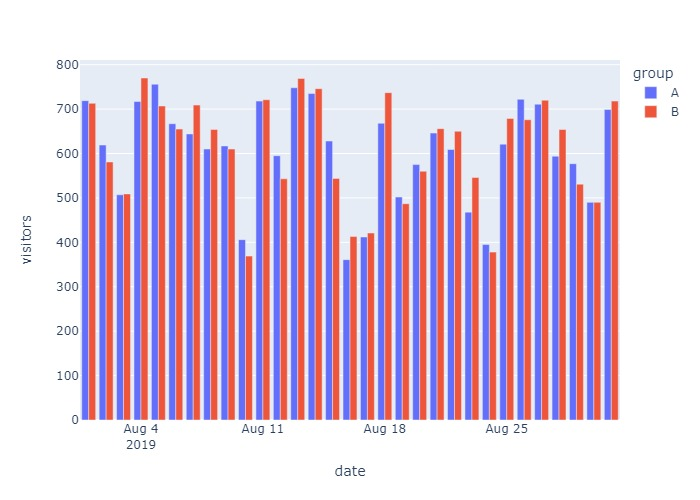

In [15]:
# график динамики посетителей по дням
fig = px.bar(visitors, x='date', y='visitors', color='group', barmode='group')
fig.show('jpg')

### Кумулятивная выручка по группам

In [16]:
# создаем массив уникальных пар значений дат и групп теста
groups = orders[['date','group']].drop_duplicates()

In [17]:
orders_agg = (
    groups.apply(lambda x:
                 orders[(orders['date'] <= x['date']) & (orders['group'] == x['group'])]
                 .agg({'date': 'max',
                       'group': 'max',
                       'transactionId': 'nunique',
                       'visitorId': 'nunique',
                       'revenue': 'sum'}),
                 axis=1)
    .rename(columns={'transactionId': 'orders_count', 'visitorId': 'paying_users'})
    .sort_values(by=['date', 'group'])
)
orders_agg.head()

,date,group,orders_count,paying_users,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [18]:
visitors_agg = (
    groups.apply(lambda x:
                visitors[(visitors['date'] <= x['date']) & (visitors['group'] == x['group'])]
                 .agg({'date': 'max',
                       'group': 'max',
                       'visitors': 'sum'}),
                 axis=1)
    .rename(columns={'visitors': 'users_count'})
    .sort_values(by=['date', 'group'])
)
visitors_agg.head()

,date,group,users_count
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [19]:
cumulative_data = orders_agg.merge(
    visitors_agg, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.head()

,date,group,orders_count,paying_users,revenue,users_count
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [20]:
# проверка дат

cum_min_date = cumulative_data['date'].dt.date.min()
cum_max_date = cumulative_data['date'].dt.date.max()
visitors_min_date = visitors['date'].dt.date.min()
visitors_max_date = visitors['date'].dt.date.max()
orders_min_date = orders['date'].dt.date.min()
orders_max_date = orders['date'].dt.date.max()

if (visitors_min_date == orders_min_date 
    and cum_min_date == visitors_min_date 
    and visitors_min_date == orders_min_date
    and visitors_max_date == orders_max_date
    and cum_max_date == visitors_max_date):
    print('Минимальная и максимальная дата в cumulative_data совпадают с исходными данными.')
else:
    print('Даты не совпадают, требуется проверка.')

Минимальная и максимальная дата в cumulative_data совпадают с исходными данными.


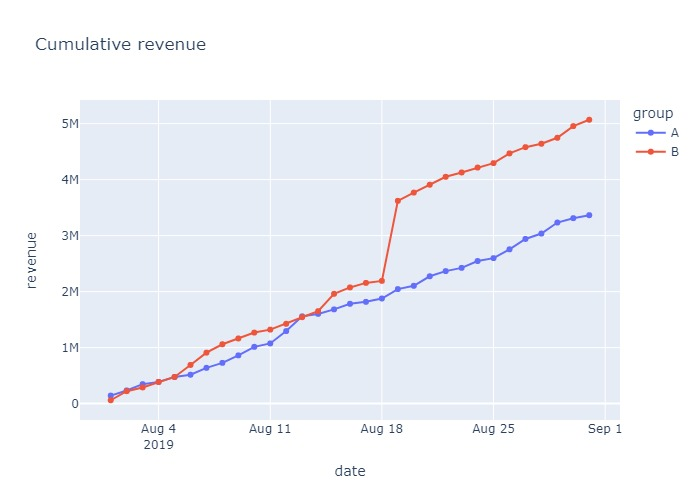

In [21]:
# кумулятивная выручка по группам
fig = px.line(cumulative_data, x='date', y='revenue', color='group', title='Cumulative revenue', markers=True)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- графики кумулятивной выручки для обоих групп равномерно растут;<br>
- 19 августа у группы <i>B</i> наблюдается скачок выручки, вероятные причины:<br>
    - резкое увеличение числа заказов;<br>
    - оформлен очень большой заказ.

### Кумулятивный средний чек

In [22]:
cumulative_data['avg_bill'] = cumulative_data['revenue'] / cumulative_data['orders_count']

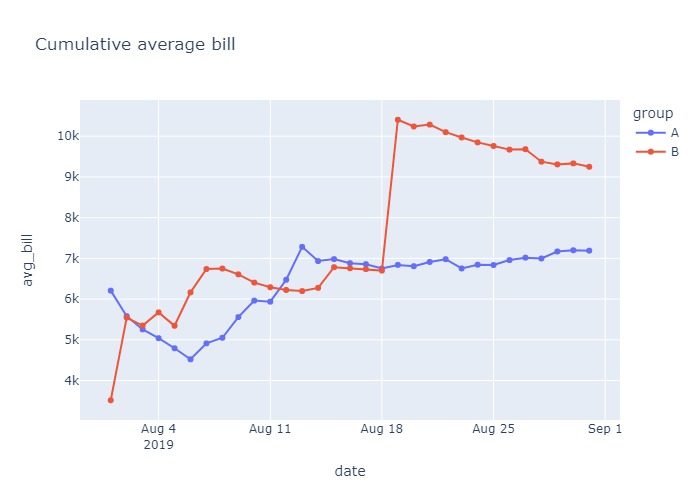

In [23]:
# кумулятивный средний чек по группам
fig = px.line(cumulative_data, x='date', y='avg_bill', color='group', title='Cumulative average bill', markers=True)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- до 19 августа обе группы растут;
- 19 августа средний чек группы <i>B</i> вырастает скачком;
- после 19 августа средний чек группы <i>B</i> постепенно снижается.

### Относительное изменение кумулятивного среднего чека

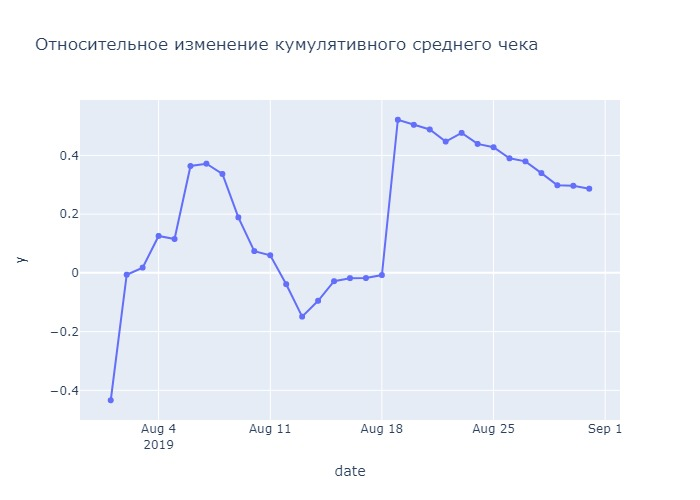

In [24]:
avg_bill_a = cumulative_data.query('group == "A"')[['date', 'avg_bill']]
avg_bill_b = cumulative_data.query('group == "B"')[['date', 'avg_bill']]

avgs = avg_bill_a.merge(avg_bill_b, on='date', how='left', suffixes=['_a', '_b'])

fig = px.line(avgs,
              x='date',
              y=(avgs['avg_bill_b'] / avgs['avg_bill_a'] - 1),
              title='Относительное изменение кумулятивного среднего чека',
              markers=True)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- 19 августа всё тот же скачок, требуется проверить аномальные значения;<br>
- за исключением скачка 19 августа средний чек группы <i>B</i> в целом снижется относительно среднего чека группы <i>A</i>, начиная с 8 августа. 

### Кумулятивная конверсия по группам

Предлагаемая метрика больше похожа на TPU, чем на конверсию :)<br>
Мы не можем посчитать конверсию посетителей в покупателей, т.к. в представленных данных все посетители — покупатели.

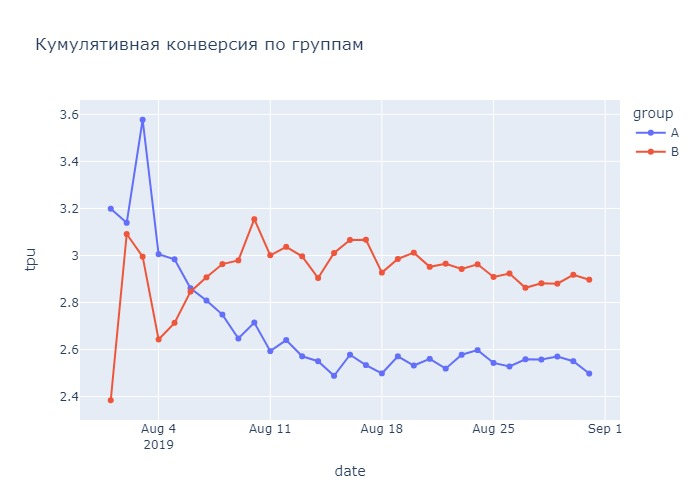

In [25]:
cumulative_data['tpu'] = cumulative_data['orders_count'] / cumulative_data['users_count'] * 100
fig = px.line(cumulative_data, x='date', y='tpu', color='group', title='Кумулятивная конверсия по группам', markers=True)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- скачка 19 августа у группы <i>B</i> нет, значит дело не в числе чеков;<br>
- группа <i>B</i> лучше группы <i>A</i> по числу чеков на покупателя.

### Относительное изменение конверсии

<a id='cr'></a>

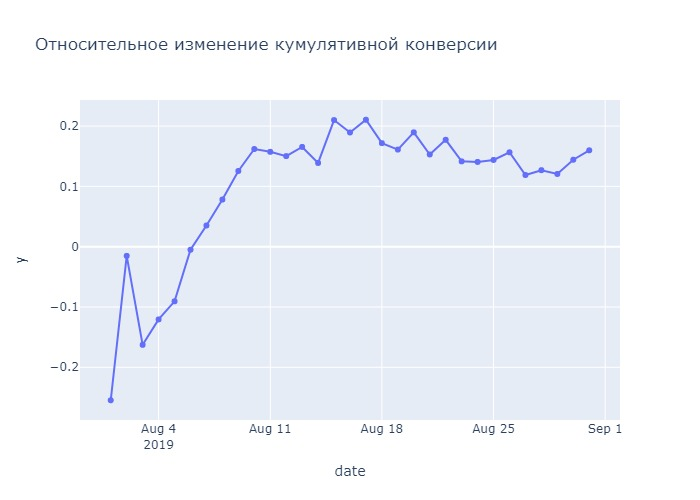

In [26]:
tpu_a = cumulative_data.query('group == "A"')[['date', 'tpu']]
tpu_b = cumulative_data.query('group == "B"')[['date', 'tpu']]

tpus = tpu_a.merge(tpu_b, on='date', how='left', suffixes=['_a', '_b'])

fig = px.line(tpus,
              x='date',
              y=(tpus['tpu_b'] / tpus['tpu_a'] - 1),
              title='Относительное изменение кумулятивной конверсии',
              markers=True)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- конверсия группы <i>B</i> интенсивно росла относительно группы <i>A</i> до 10 августа.

### Число заказов по пользователям

In [27]:
orders_by_users = (
    orders.groupby('visitorId', as_index=False) \
    .agg({'transactionId': 'nunique'})
    .rename(columns={'transactionId': 'orders_count'})
)

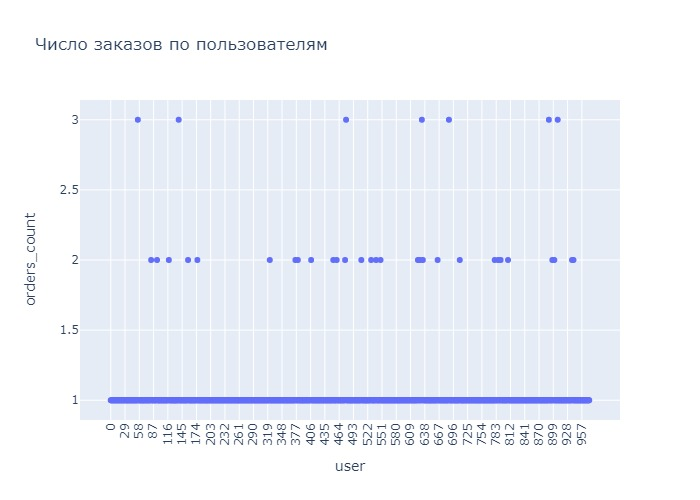

In [28]:
fig = px.scatter(orders_by_users,
                 x=pd.Series(range(0,len(orders_by_users['visitorId']))),
                 y='orders_count',
                 title='Число заказов по пользователям',
                 labels={'x':'user'}
                )
fig.update_xaxes(type='category', tickangle=-90, dtick=0)
fig.show('jpg')

<b>Выводы из графика:</b><br>
- в основной массе покупатели совершают по одной покупке.<br>

### Граница определения аномальных пользователей

In [29]:
abnormal_user_95 = (np.percentile(orders_by_users['orders_count'], 95))
abnormal_user_99 = (np.percentile(orders_by_users['orders_count'], 99))
print('95-й выборочный перцентиль количества заказов по пользователям:', abnormal_user_95)
print('99-й выборочный перцентиль количества заказов по пользователям:', abnormal_user_99)

95-й выборочный перцентиль количества заказов по пользователям: 1.0
99-й выборочный перцентиль количества заказов по пользователям: 2.0


<b>Вывод</b>:
- Не более, чем 5% покупателей произвело более 1 заказа. 
- Не более, чем 1% покупателей произвело более 2 заказов.
- Аномальным можно считать число заказов более 2 на пользователя.

### Стоимость заказов

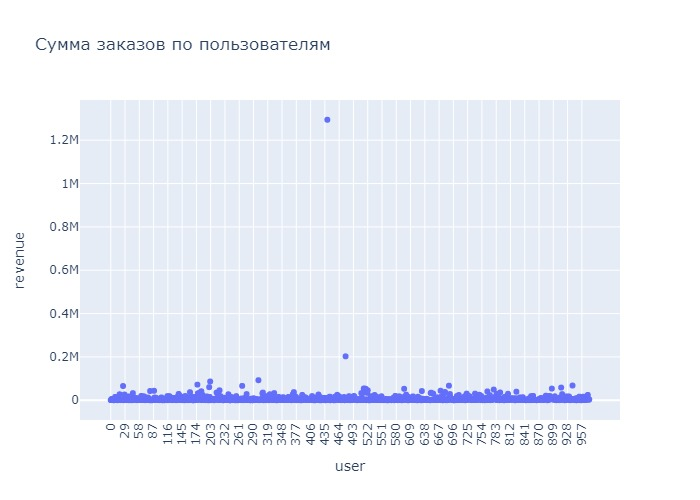

In [30]:
revenue_by_users = (
    orders.groupby('visitorId', as_index=False) \
    .agg({'revenue': 'sum'})
)
fig = px.scatter(revenue_by_users,
                 x=pd.Series(range(0,len(orders_by_users['visitorId']))),
                 y='revenue',
                 title='Сумма заказов по пользователям',
                 labels={'x':'user'})
fig.update_xaxes(type='category', tickangle=-90, dtick=0)
fig.show('jpg')

Ограничим этот график и выведем только те суммы, которые попадают в 99 перцентиль.

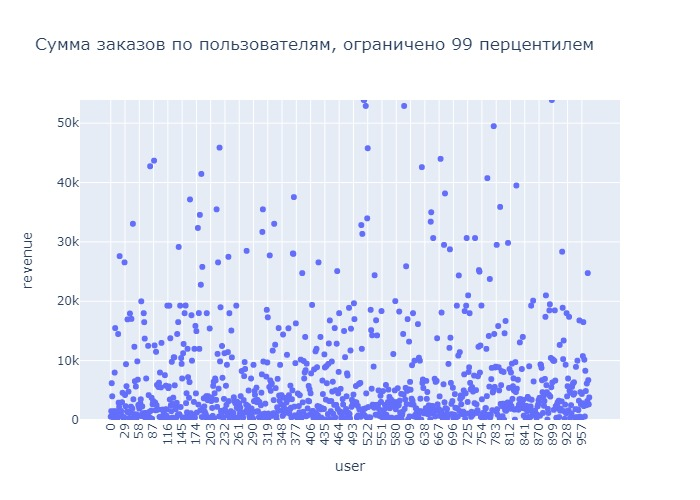

In [31]:
fig = px.scatter(revenue_by_users,
                 x=pd.Series(range(0,len(orders_by_users['visitorId']))),
                 y='revenue',
                 title='Сумма заказов по пользователям, ограничено 99 перцентилем',
                 labels={'x':'user'})
fig.update_xaxes(type='category', tickangle=-90, dtick=0)
fig.update_yaxes(range=[0, round(np.percentile(orders['revenue'], 99), 0)])
fig.show('jpg')

<b>Вывод по графикам</b>:
- есть 1 крупный заказ.

###  Выбор границы аномальных заказов

In [32]:
abnormal_orders_95 = (np.percentile(orders['revenue'], 95)).round()
abnormal_orders_99 = (np.percentile(orders['revenue'], 99)).round()
print('95-й выборочный перцентиль стоимости заказов по пользователям:', abnormal_orders_95)
print('99-й выборочный перцентиль стоимости заказов по пользователям:', abnormal_orders_99)

95-й выборочный перцентиль стоимости заказов по пользователям: 26785.0
99-й выборочный перцентиль стоимости заказов по пользователям: 53904.0


<b>Вывод</b>:
- Не более, чем 5% заказов дороже 26 785 руб. 
- Не более, чем 1% заказов дороже 53 904 руб.
- Заказы свыше 26 785 руб. можно рассматривать как аномальные.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

<b>Введем нулевую и альтернативные гипотезы</b>:

$\begin{equation*}
    \begin{cases}
        H_0 :\text{Различий в конверсии между группами нет.}\\
        H_1 :\text{Различия в конверсии между группами есть.}
    \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Если p-value меньше выбранного уровня значимости ($\alpha = 0.05$), есть основания отвергнуть нулевую гипотезу в пользу альтернативной.<br>
Иначе, данные не позволили отвергнуть нулевую гипотезу.

In [33]:
# Сбор данных

# Группа А
daily_visitors_a = visitors.query('group == "A"')[['date', 'visitors']]

# С помощью lambda-функции итерируемся по каждой строке датафрейма и сравниваем: 
# если дата или даты (если прошли больше n итераций) (daily_visitors_a['date']) 
# меньше даты в текущей ячейке, в которой мы находимся на конкретном шаге итерации (x['date']), 
# то суммируй ее/их значения столбца visitors со значением visitors в текущей ячейке ('visitors': 'sum'), 
# а дату оставляй максимальную из 2-х/3-х/n ('date': 'max'). 
# Таким образом, получаем кумулятивную сумму для каждой даты, учитывая предыдущие (меньшие) даты.

cum_visitors_a = daily_visitors_a.apply(
    lambda x: daily_visitors_a[daily_visitors_a['date'] <= x['date']]
    .agg({'date': 'max',
          'visitors': 'sum'}), axis=1)

cum_visitors_a.columns = [
    'date', 
    'num_visitors_a'
]

daily_orders_a = (
    orders
    .query('group == "A"')[['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique',
          'revenue': 'sum'})
)


cum_orders_a = daily_orders_a.apply(
    lambda x: daily_orders_a[daily_orders_a['date'] <= x['date']]
    .agg({'date': 'max', 
          'transactionId': 'sum', 
          'revenue': 'sum'}), axis=1).sort_values(by=['date'])

cum_orders_a.columns = [
    'date',
    'num_orders_a',
    'revenue_a',
]

In [34]:
# Группа B
daily_visitors_b = visitors.query('group == "B"')[['date', 'visitors']]

cum_visitors_b = daily_visitors_b.apply(
    lambda x: daily_visitors_b[daily_visitors_b['date'] <= x['date']] # 
    .agg({'date': 'max',
          'visitors': 'sum'}), axis=1)

cum_visitors_b.columns = [
    'date', 
    'num_visitors_b'
]

daily_orders_b = (
    orders
    .query('group == "B"')[['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique',
          'revenue': 'sum'})
)


cum_orders_b = daily_orders_b.apply(
    lambda x: daily_orders_b[daily_orders_b['date'] <= x['date']]
    .agg({'date': 'max', 
          'transactionId': 'sum', 
          'revenue': 'sum'}), axis=1).sort_values(by=['date'])

cum_orders_b.columns = [
    'date',
    'num_orders_b',
    'revenue_b',
]

In [35]:
# Объединение

final_data = (
    daily_orders_a.merge(
        daily_orders_b, left_on='date', right_on='date', how='left'
    )
    .merge(cum_orders_a, left_on='date', right_on='date', how='left')
    .merge(cum_orders_b, left_on='date', right_on='date', how='left')
    .merge(daily_visitors_a, left_on='date', right_on='date', how='left')
    .merge(daily_visitors_b, left_on='date', right_on='date', how='left')
    .merge(cum_visitors_a, left_on='date', right_on='date', how='left')
    .merge(cum_visitors_b, left_on='date', right_on='date', how='left')
)

In [36]:
# Переменные для определения статистической значимости в конверсии между группами по «сырым» данным

# Группа А
orders_by_users_a = (
    orders.query('group == "A"')
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

orders_by_users_a.columns = ['visitorId', 'num_orders']

sample_a = pd.concat(
    [
        orders_by_users_a['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_x'].sum() - len(orders_by_users_a['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [37]:
# Группа В

orders_by_users_b = (
    orders.query('group == "B"')
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

orders_by_users_b.columns = ['visitorId', 'num_orders']

sample_b = pd.concat(
    [
        orders_by_users_b['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_y'].sum() - len(orders_by_users_b['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [38]:
alpha = .05

results = stats.mannwhitneyu(sample_a, sample_b, alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к конверсии группы А в процентах:',
      "{0:.2f}".format(((final_data['transactionId_y'].sum() / final_data['visitors_y'].sum()) /
      (final_data['transactionId_x'].sum() / final_data['visitors_x'].sum()) - 1) * 100), '%')

p-value: 0.011018
Имеются основания отвергнуть нулевую гипотезу
Относительный прирост конверсии группы В к конверсии группы А в процентах: 15.98 %


<a id='raw_cr'></a>
<b>Вывод</b>:
- На доступных данных на 5% уровне значимости имеются основания отвергнуть нулевую гипотезу в пользу альтернативной (`p-value` меньше уровня значимости (0.05)).
- Обнаружены статистически значимые различия между группами. Есть существенное различие в конверсиях пользователей групп A и B.
- Относительный прирост конверсии группы В к конверсии группы А равен 15.98%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**Введем нулевую и альтернативные гипотезы**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Различий в среднем чеке между группами нет}\\
   H_1 :\text{Различия в среднем чеке между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [39]:
results = stats.mannwhitneyu(
    orders.query('group == "A"')['revenue'],
    orders.query('group == "B"')['revenue'],
    alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')
    
print('Относительный прирост среднего чека группы B:',
      '{0:.2f}'.format((orders.query('group == "B"')['revenue'].mean() /
                        orders.query('group == "A"')['revenue'].mean() - 1) * 100), '%')

p-value: 0.829491
Недостаточно оснований, чтобы отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B: 28.66 %


<a id='raw_bill'></a>
<b>Вывод</b>:
- На доступных данных на 5% уровне значимости недостаточно оснований, чтобы отвергнуть нулевую гипотезу в пользу альтернативной.
- Статистически значимых различий между группами нет.
- Относительный прирост среднего чека группы В к среднему чеку группы А равен 28.66%. На данное значение могли повлиять выбросы, которые мы наблюдали на графиках ранее.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным.

In [40]:
# Выделение аномальных записей

abnormal_orders = pd.concat(
    [
        orders_by_users_a.query('num_orders > @abnormal_user_99')['visitorId'],
        orders_by_users_b.query('num_orders > @abnormal_user_99')['visitorId']
    ],
    axis=0,
)

abnormal_revenue = orders[orders['revenue'] > abnormal_orders_95]['visitorId']

abnormal_data = (
    pd.concat([abnormal_orders, abnormal_revenue], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [41]:
sample_a_normal = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitorId'].isin(abnormal_data))
        ]['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_x'].sum() - len(orders_by_users_a['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_normal = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitorId'].isin(abnormal_data))
        ]['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_y'].sum() - len(orders_by_users_b['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [42]:
results = stats.mannwhitneyu(
    sample_a_normal, 
    sample_b_normal, 
    alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к конверсии группы А:',
      '{0:.2f}'.format((sample_b_normal.mean() / sample_a_normal.mean() - 1) * 100), '%')

p-value: 0.012352
Имеются основания отвергнуть нулевую гипотезу
Относительный прирост конверсии группы В к конверсии группы А: 18.19 %


<a id='ref_cr'></a>
<b>Вывод</b>:
- На доступных данных на 5% уровне значимости имеются основания отвергнуть нулевую гипотезу в пользу альтернативной.
- Обнаружены статистически значимые различия между группами. Есть существенное различие в конверсиях пользователей групп <i>A</i> и <i>B</i>.
- Относительный прирост конверсии группы В к конверсии группы <i>А</i> равен 18.19%. Значение близко к значению, полученному на "сырых" данных. Конверсия не сильно зависела от аномалий и выбросов. По значению относительного прироста конверсии можно сделать вывод о том, что группа <i>В</i> показала себя лучше.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [43]:
results = stats.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormal_data))
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormal_data))
        )
    ]['revenue'])[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергнуть нулевую гипотезу')
    
print(
    'Относительный прирост среднего чека группы B к среднему чеку группы А:',
    "{0:.2f}".format((
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_data)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormal_data)),
            )
        ]['revenue'].mean() - 1) * 100), '%') 

p-value: 0.322948
Недостаточно оснований, чтобы отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B к среднему чеку группы А: -4.85 %


<a id='ref_bill'></a>
<b>Вывод</b>:
- На доступных данных на 5% уровне значимости не имеется основания отвергнуть нулевую гипотезу в пользу альтернативной.
- Не обнаружено статистически значимых различий между группами.
- Относительный прирост среднего чека группы <i>B</i> к среднему чеку группы <i>А</i>: -4.85 %. Различие связано с удалением выбросов.

### Решение по результатам теста

Из исследования имеем:
- тест проводился на <a href="#Группы" data-toc-modified-id="Группы-2.1">2х группах</a> с <a href="#Временные-интервалы-проведения-теста" data-toc-modified-id="Временные-интервалы-проведения-теста-2.1.2">01 по 31 августа 2019 года</a>;  
- есть статистически значимые различия по конверсии между группами и [по «сырым» данным](#raw_cr), и по данным [после фильтрации](#ref_cr) аномалий;
- нет статистически значимого различия по среднему чеку между группами ни [по «сырым»](#raw_bill), ни по данным [после фильтрации](#ref_bill) аномалий;
- [рост](#cr) относительной конверсии.

**Решение**<br>
Исходя из обнаруженных фактов, тест следует остановить и зафиксировать преимущество **группы <i>B</i>**.<br>
При постоянном относительном среднем чеке растёт относительная конверсия, значит, растёт и выручка.